In [1]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

import pathlib
import os, sys


In [2]:
# data download


# path_2_zip = tf.keras.utils.get_file('spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
#     extract=True)

# path_2_file = pathlib.Path(path_2_zip).parent/'spa-eng/spa.txt'

# print(path_2_file)
# print(path_2_zip)

In [3]:
#data path
fileDir = os.path.dirname(os.path.realpath('__file__'))
filename = pathlib.Path(os.path.join(fileDir, r"dataset\spa.txt"))

print(filename)

F:\program repo\NLP-translation\dataset\spa.txt


In [4]:
def load_data(path):
    text = path.read_text(encoding='utf-8')

    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]

    context = np.array([context for target, context in pairs])
    target = np.array([target for target, context in pairs])

    return target, context



In [5]:
target_raw, context_raw = load_data(filename)

In [6]:
#check data
print(target_raw[0])
print(context_raw[0])

Go.
Ve.


In [7]:
#meta data

max_vocab_size = 5000

buffer_size = len(context_raw)
batch_size = 64

train_set_proportion = 0.8

is_train = np.random.uniform(size=(len(target_raw), )) < train_set_proportion



In [8]:
#set up tf dataset
train_set_raw = (
    tf.data.Dataset.from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(buffer_size)
    .batch(batch_size)
)

val_set_raw = (
    tf.data.Dataset.from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(buffer_size)
    .batch(batch_size)
)

In [9]:
#data check

for context_strings, target_strings in train_set_raw.take(1):
    print(context_strings[:6])
    print()
    print(target_strings[:6])
    break

tf.Tensor(
[b'Ella dej\xc3\xb3 su trabajo el mes pasado.'
 b'Yo necesito que me lleven.' b'La ni\xc3\xb1a es chica para su edad.'
 b'Reportamos su desaparici\xc3\xb3n.' b'Yo nunca vi un OVNI.'
 b'\xc3\x89l se qued\xc3\xb3 despierto toda la noche.'], shape=(6,), dtype=string)

tf.Tensor(
[b'She quit her job last month.' b'I need a ride.'
 b'The girl is small for her age.' b'We reported his disappearance.'
 b'I myself have never seen a UFO.' b'He stayed up all night.'], shape=(6,), dtype=string)


In [10]:
def tf_lower_and_split_punct(text):
    #split accented characters
    text = tf_text.normalize_utf8(text, 'NFKD') #NFKD is one of the normalization format defined in unicode convention
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text


In [11]:
#check

example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

print(example_text.numpy().decode())

print(tf_lower_and_split_punct(example_text).numpy().decode())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'
¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


In [12]:
#Text vectoriazation

context_text_preprocessor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True
)

In [13]:
context_text_preprocessor.adapt(train_set_raw.map(lambda context, target: context))

In [14]:
#output check
context_text_preprocessor.get_vocabulary()[:15]

['',
 '[UNK]',
 '[START]',
 '[END]',
 '.',
 'que',
 'de',
 'el',
 'a',
 'no',
 'tom',
 'la',
 '?',
 '¿',
 'en']

In [15]:
target_text_preprocessor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True
)



In [16]:
target_text_preprocessor.adapt(train_set_raw.map(lambda context, target: target))

In [17]:
#output check
target_text_preprocessor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [18]:
example_tokens = context_text_preprocessor(context_strings)
print(example_tokens[ : 3])

<tf.RaggedTensor [[2, 28, 263, 25, 83, 7, 363, 181, 4, 3], [2, 39, 153, 5, 18, 1, 4, 3],
 [2, 11, 575, 15, 507, 31, 25, 420, 4, 3]]>


In [19]:
#convert token value back to words

context_vocab = np.array(context_text_preprocessor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
print(' '.join(tokens))


target_vocab = np.array(target_text_preprocessor.get_vocabulary())
tk2 = target_vocab[target_text_preprocessor(target_strings)[0].numpy()]
print(' '.join(tk2))

[START] ella dejo su trabajo el mes pasado . [END]
[START] she quit her job last month . [END]


Text(0.5, 1.0, 'Mask')

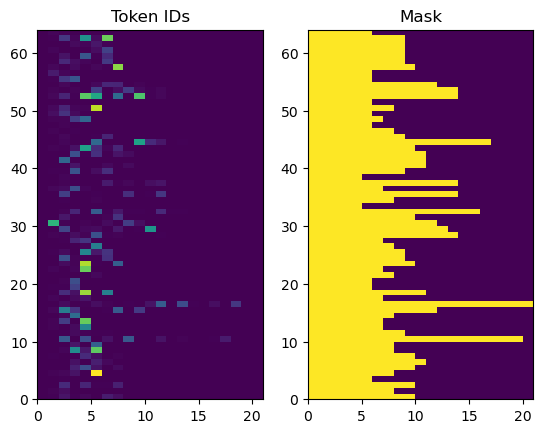

In [20]:
# visualization

plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [21]:
def process_text(context, target):
    context = context_text_preprocessor(context).to_tensor()
    target = target_text_preprocessor(target)
    targ_in = target[:,:-1].to_tensor()
    targ_out = target[:,1:].to_tensor()
    return (context, targ_in), targ_out

train_ds = train_set_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_set_raw.map(process_text, tf.data.AUTOTUNE)

In [22]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(5):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy())

[  2  18 720   4   3   0   0   0   0   0]

[  2   6 628   4   0   0   0   0   0   0]
[  6 628   4   3   0   0   0   0   0   0]
[   2   13    5  234 3545    8 1143   12    3    0]

[  2  29 281   8  28  76   7 105  11   0]
[ 29 281   8  28  76   7 105  11   3   0]
[   2   48    5 3207    4    3    0    0    0    0]

[  2   6  37   8   7 223   4   0   0   0]
[  6  37   8   7 223   4   3   0   0   0]
[   2   17    1   16    1    1   14 2347   37    1]

[   2   72    1 4534   18 3845   14 2202   15    5]
[  72    1 4534   18 3845   14 2202   15    5    1]
[   2   39   67  522    6 3319    4    3    0    0]

[  2   6  18 286   7  92  47   4   0   0]
[  6  18 286   7  92  47   4   3   0   0]


# ENCODER

In [23]:
units = 256

In [24]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_preprocessor, units):
        super(Encoder, self).__init__()
        self.text_preprocessor = text_preprocessor
        self.vocab_size = text_preprocessor.vocabulary_size()
        self.units = units
    

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)

        # The RNN layer processes those vectors sequentially.
        self.rnn = tf.keras.layers.Bidirectional(
            layer=tf.keras.layers.GRU(
                units,
                return_sequences=True,
                recurrent_initializer='glorot_uniform'
            )
        )


    def call(self, x):
        shape_checker = ShapeChecker()
        shape_checker(x, 'batch s')

        # 2. The embedding layer looks up the embedding vector for each token.
        x = self.embedding(x)
        shape_checker(x, 'batch s units embedding')

        # 3. The GRU processes the sequence of embeddings.
        x = self.rnn(x)
        shape_checker(x, 'batch s units rnn')

        # 4. Returns the new sequence of embeddings.
        return x

    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)

        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_preprocessor(texts).to_tensor()
        context = self(context)
        return context